# Homework 2. Team 4, MLBA group 3.
World Happiness Report 2015–2024: regression task

Eugenia Zolotukhina, Natalia Murchich & Fidan Akhundova








## 1. Import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from mlba import regressionSummary
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

## 2. Load dataset

In [8]:
df = pd.read_csv('world_happiness_combined.csv', sep = ';', decimal = ',')
df.head()

,Ranking,Country,Regional indicator,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
0,1,Switzerland,Western Europe,7.587,8.26132,0.96240,73,0.99379,0.37289,0.23941,2015
1,2,Iceland,Western Europe,7.561,7.70416,1.00000,73,0.93884,0.54819,0.74371,2015
2,3,Denmark,Western Europe,7.527,7.84114,0.97030,70,0.96962,0.42894,0.12382,2015
3,4,Norway,Western Europe,7.522,8.63100,0.94917,71,1.00000,0.43598,0.33860,2015
4,5,Canada,North America and ANZ,7.427,7.84595,0.94322,71,0.94511,0.57560,0.40285,2015


In [9]:
print('Dataset shape:', df.shape)

Dataset shape: (1502, 11)


In [10]:
print('\nColumn information:')
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ranking                       1502 non-null   int64  
 1   Country                       1502 non-null   object 
 2   Regional indicator            1499 non-null   object 
 3   Happiness score               1502 non-null   float64
 4   GDP per capita                1502 non-null   float64
 5   Social support                1502 non-null   float64
 6   Healthy life expectancy       1502 non-null   int64  
 7   Freedom to make life choices  1502 non-null   float64
 8   Generosity                    1502 non-null   float64
 9   Perceptions of corruption     1502 non-null   float64
 10  Year                          1502 non-null   int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 129.2+ KB
None


In [11]:
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
Ranking                         0
Country                         0
Regional indicator              3
Happiness score                 0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
Year                            0
dtype: int64


## 3. Exploratory data analysis (EDA)

In [12]:
# 3.1 Basic statistics for numerical features
df.describe().round(2)

,Ranking,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
count,1502.00,1502.00,1502.00,1502.00,1502.00,1502.00,1502.00,1502.00,1502.00
mean,76.04,5.45,6.11,0.69,66.67,0.66,0.32,0.45,2019.37
std,43.87,1.13,2.50,0.21,7.67,0.22,0.17,0.32,2.86
min,1.00,1.72,0.00,0.00,39.00,0.00,0.00,0.00,2015.00
25%,38.00,4.59,4.38,0.56,62.00,0.54,0.20,0.16,2017.00
50%,76.00,5.47,6.31,0.74,68.00,0.69,0.30,0.35,2019.00
75%,114.00,6.28,8.05,0.86,72.00,0.83,0.43,0.78,2022.00
max,158.00,7.84,10.00,1.00,85.00,1.00,1.00,1.00,2024.00


In [13]:
# 3.2 Distribution by year
print('\nDistribution by year:')
print(df['Year'].value_counts().sort_index())


Distribution by year:
Year
2015    158
2016    157
2017    155
2018    155
2019    155
2020    152
2021    148
2022    145
2023    137
2024    140
Name: count, dtype: int64


In [14]:
# 3.3 Distribution by region (including missing values)
print('\nDistribution by region (including missing values):')
print(df['Regional indicator'].value_counts(dropna = False))


Distribution by region (including missing values):
Regional indicator
Sub-Saharan Africa                    370
Western Europe                        232
Latin America and Caribbean           209
Middle East and North Africa          189
Central and Eastern Europe            141
Commonwealth of Independent States    103
Southeast Asia                         82
East Asia                              68
South Asia                             65
North America and ANZ                  40
NaN                                     3
Name: count, dtype: int64


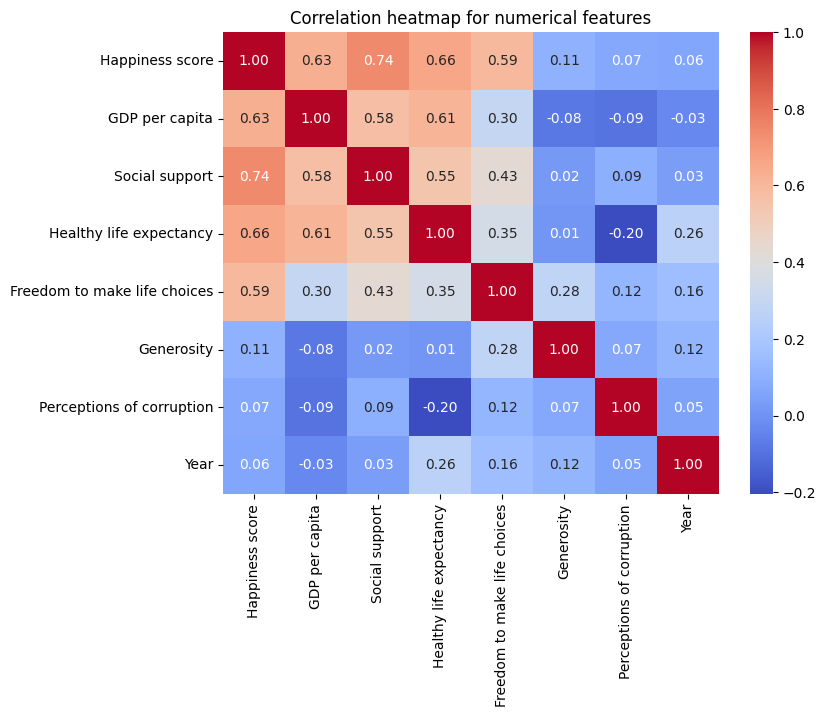

In [15]:
# 3.4 Correlation heatmap for numerical features
numeric_cols = [
    'Happiness score',
    'GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption',
    'Year'
]

plt.figure(figsize = (8,6))
sns.heatmap(df[numeric_cols].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation heatmap for numerical features');

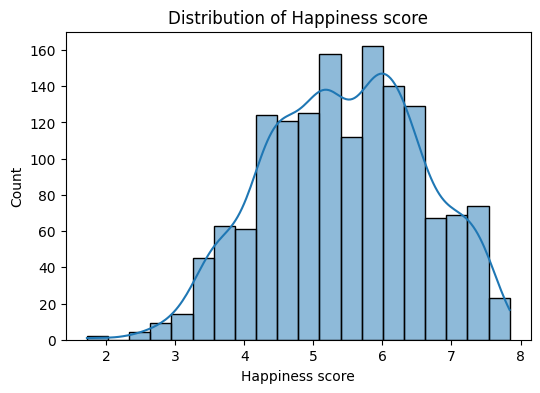

In [16]:
# 3.5 Distribution of Happiness score
plt.figure(figsize = (6,4))
sns.histplot(df['Happiness score'], bins = 20, kde = True)
plt.title('Distribution of Happiness score')
plt.xlabel('Happiness score');

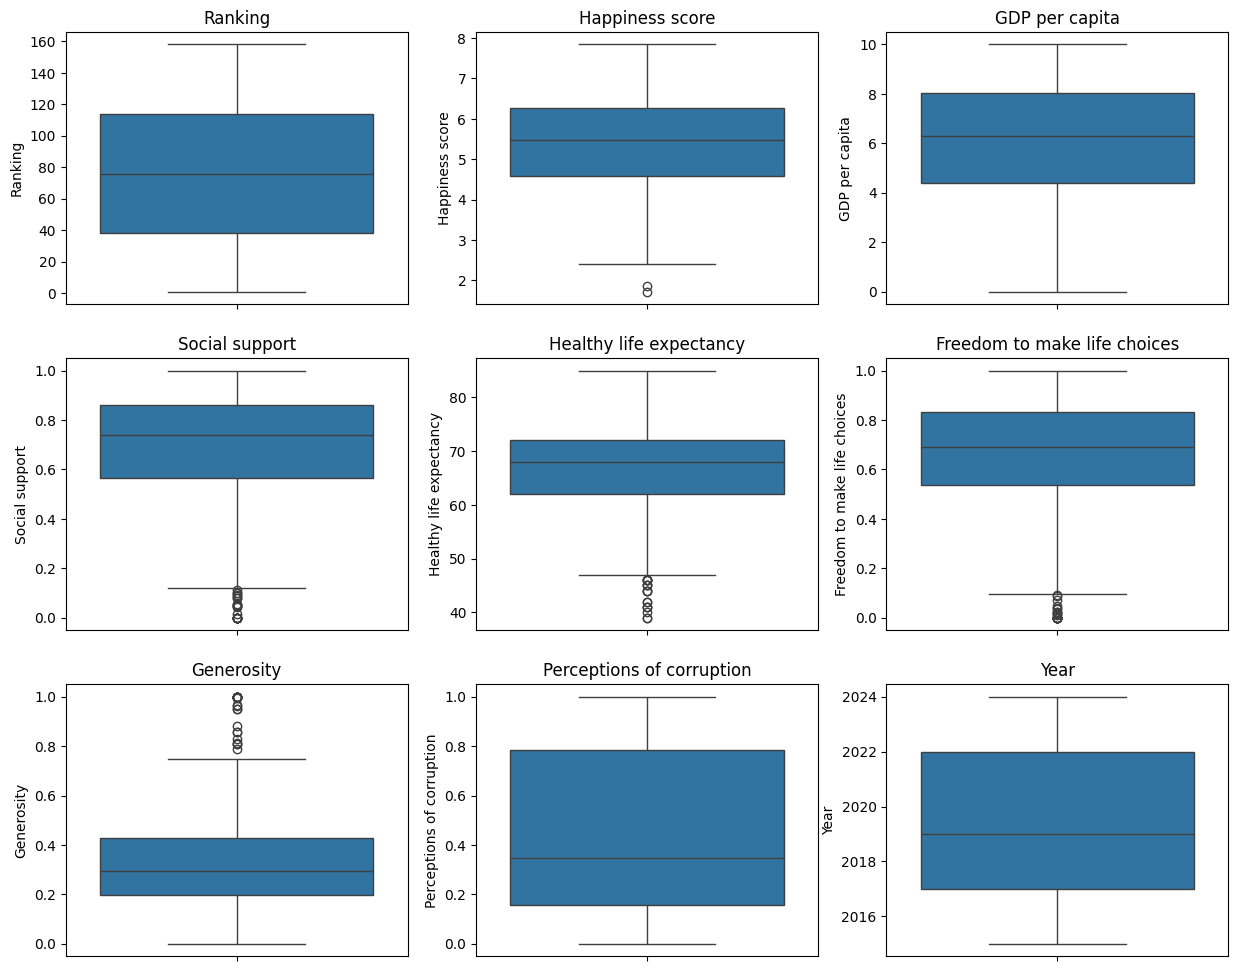

In [17]:
# 3.6 Boxplots for all numerical features
numeric_cols = df.select_dtypes(include = ['number']).columns

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize = (5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y = df[col])
    plt.title(col)
    plt.xlabel('');

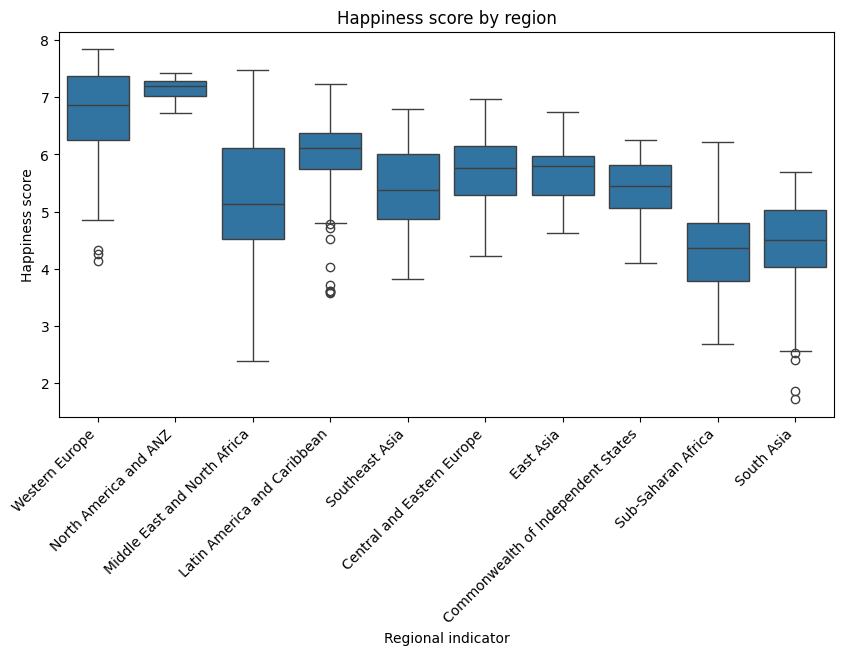

In [18]:
# 3.7 Boxplot of Happiness score by region
plt.figure(figsize = (10,5))
sns.boxplot(data=df, x = 'Regional indicator', y = 'Happiness score')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Happiness score by region');

## 4. Data preprocessing and feature selection

In [19]:
# Replacement of missing values with regions from geography
country_region_map = {
    'Greece': 'Southern Europe',
    'Cyprus': 'Middle East and North Africa',
    'Gambia': 'West Africa'
}

for country, region in country_region_map.items():
    df.loc[df['Country'] == country, 'Regional indicator'] = region

target_col = 'Happiness score'

numeric_features = [
    'GDP per capita', 'Social support', 'Healthy life expectancy',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Year', 'Country_encoded'
]

cat_feature = 'Regional indicator'

# Label Encoding for countries
le_country = LabelEncoder()
df['Country_encoded'] = le_country.fit_transform(df['Country'])

In [20]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[numeric_features])

X_cat = pd.get_dummies(df[cat_feature], prefix = 'region')

X_num_scaled = pd.DataFrame(
    X_num_scaled,
    columns = numeric_features,
    index = df.index
)

X = pd.concat([X_num_scaled, X_cat], axis = 1)
y = df[target_col]
X

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year,Country_encoded,region_Central and Eastern Europe,region_Commonwealth of Independent States,region_East Asia,region_Latin America and Caribbean,region_Middle East and North Africa,region_North America and ANZ,region_South Asia,region_Southeast Asia,region_Southern Europe,region_Sub-Saharan Africa,region_West Africa,region_Western Europe
0,0.862092,1.272755,0.825363,1.547611,0.304272,-0.663252,-1.532145,1.266177,False,False,False,False,False,False,False,False,False,False,False,True
1,0.639115,1.449632,0.825363,1.293646,1.319847,0.904459,-1.532145,-0.420081,False,False,False,False,False,False,False,False,False,False,False,True
2,0.693935,1.309918,0.434168,1.435904,0.628990,-1.022585,-1.532145,-0.901869,False,False,False,False,False,False,False,False,False,False,False,True
3,1.010038,1.210518,0.564567,1.576312,0.669775,-0.354901,-1.532145,0.583644,False,False,False,False,False,False,False,False,False,False,False,True
4,0.695860,1.182528,0.564567,1.322625,1.478643,-0.155168,-1.532145,-1.202987,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,-2.444104,0.590647,0.434168,-0.272846,0.923003,-0.941759,1.619816,1.687742,False,False,False,True,False,False,False,False,False,False,False,False
1498,0.043467,0.432492,0.564567,1.465113,-0.502162,-0.542728,1.619816,1.707816,False,False,False,False,False,False,False,True,False,False,False,False
1499,-1.189047,0.474595,-0.348220,-1.105498,-0.698036,-0.795775,1.619816,1.727891,False,False,False,False,True,False,False,False,False,False,False,False
1500,-0.763344,-0.900534,-0.478618,0.846817,0.567059,-0.816479,1.619816,1.747966,False,False,False,False,False,False,False,False,False,True,False,False


## 5. Train–test split

In [21]:
# partition data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    random_state = 42
)

## 6. Model training

In [22]:
# fit model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [23]:
# prediction train set
train_pred = model.predict(X_train)
train_results = pd.DataFrame({
    'Happiness_score': y_train,
    'predicted': train_pred,
    'residual': y_train - train_pred,
})

train_results.head()

,Happiness_score,predicted,residual
527,7.4952,6.911274,0.583926
199,5.1320,3.712463,1.419537
988,5.3445,5.404378,-0.059878
1326,4.8551,4.443350,0.411750
1327,4.7239,4.518172,0.205728


In [24]:
# prediction test set
holdout_pred = model.predict(X_test)
holdout_results = pd.DataFrame({
    'Happiness_score': y_test,
    'predicted': holdout_pred,
    'residual': y_test - holdout_pred,
})
holdout_results.head()

,Happiness_score,predicted,residual
1118,4.3961,4.229890,0.166210
643,6.8923,6.820593,0.071707
422,5.8380,5.108347,0.729653
413,4.4650,4.580615,-0.115615
451,4.2910,4.421227,-0.130227


In [25]:
print("Coefficients:")
print("Intercept:", model.intercept_)
for feature, coef in zip(X_num_scaled, model.coef_):
    print(f"{feature}: {coef:.4f}")

Coefficients:
Intercept: 5.503349968835278
GDP per capita: 0.1276
Social support: 0.3313
Healthy life expectancy: 0.1686
Freedom to make life choices: 0.2957
Generosity: 0.0658
Perceptions of corruption: 0.0497
Year: -0.0430
Country_encoded: -0.0357


In [26]:
# training set
print("\nTraining Set")
regressionSummary(y_true=train_results.Happiness_score, y_pred=train_results.predicted)

# holdout set
print("\nHoldout Set")
regressionSummary(y_true=holdout_results.Happiness_score, y_pred=holdout_results.predicted)



Training Set

Regression statistics

Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.5329
Mean Absolute Error (MAE) : 0.4117
Mean Percentage Error (MPE) : -1.2167
Mean Absolute Percentage Error (MAPE) : 8.4715

Holdout Set

Regression statistics

Mean Error (ME) : 0.0058
Root Mean Squared Error (RMSE) : 0.4671
Mean Absolute Error (MAE) : 0.3679
Mean Percentage Error (MPE) : -0.8358
Mean Absolute Percentage Error (MAPE) : 7.2080


In [27]:
rf_model = RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1
)

rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print('Random Forest - train set metrics:')
regressionSummary(y_true = y_train, y_pred = y_train_pred_rf)

print('\nRandom Forest - holdout set metrics:')
regressionSummary(y_true = y_test, y_pred = y_test_pred_rf)

Random Forest - train set metrics:

Regression statistics

Mean Error (ME) : -0.0036
Root Mean Squared Error (RMSE) : 0.1562
Mean Absolute Error (MAE) : 0.1167
Mean Percentage Error (MPE) : -0.4047
Mean Absolute Percentage Error (MAPE) : 2.3978

Random Forest - holdout set metrics:

Regression statistics

Mean Error (ME) : -0.0003
Root Mean Squared Error (RMSE) : 0.4095
Mean Absolute Error (MAE) : 0.3107
Mean Percentage Error (MPE) : -0.8413
Mean Absolute Percentage Error (MAPE) : 6.1278


## K-fold cross-validation for Linear Regression and Random Forest

In [28]:
scoring  =  {
    'neg_RMSE': 'neg_root_mean_squared_error',
    'neg_MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
}

cv  =  KFold(n_splits = 5, shuffle = True, random_state = 42)

# --- Linear Regression: 5-fold CV ---
lin_reg_cv  =  LinearRegression()

cv_results_lr  =  cross_validate(
    lin_reg_cv,
    X_train,
    y_train,
    cv = cv,
    scoring = scoring,
    n_jobs = -1,
    return_train_score = False,
)

rmse_lr = -cv_results_lr['test_neg_RMSE'].mean()
mae_lr = -cv_results_lr['test_neg_MAE'].mean()
r2_lr = cv_results_lr['test_R2'].mean()

# --- Random Forest: 5-fold CV ---
rf_cv  =  RandomForestRegressor(
    n_estimators = 300,
    max_depth = None,
    random_state = 42,
    n_jobs = -1,
)

cv_results_rf  =  cross_validate(
    rf_cv,
    X_train,
    y_train,
    cv = cv,
    scoring = scoring,
    n_jobs = -1,
    return_train_score = False,
)

rmse_rf = -cv_results_rf['test_neg_RMSE'].mean()
mae_rf = -cv_results_rf['test_neg_MAE'].mean()
r2_rf = cv_results_rf['test_R2'].mean()

print('5-fold cross-validation results (on training set)\n')

print('Linear Regression')
print(f'  RMSE (mean over 5 folds): {rmse_lr:.3f}')
print(f'  MAE  (mean over 5 folds): {mae_lr:.3f}')
print(f'  R^2  (mean over 5 folds): {r2_lr:.3f}\n')

print('Random Forest')
print(f'  RMSE (mean over 5 folds): {rmse_rf:.3f}')
print(f'  MAE  (mean over 5 folds): {mae_rf:.3f}')
print(f'  R^2  (mean over 5 folds): {r2_rf:.3f}')

5-fold cross-validation results (on training set)

Linear Regression
  RMSE (mean over 5 folds): 0.542
  MAE  (mean over 5 folds): 0.419
  R^2  (mean over 5 folds): 0.772

Random Forest
  RMSE (mean over 5 folds): 0.436
  MAE  (mean over 5 folds): 0.327
  R^2  (mean over 5 folds): 0.852


## Hyperparameter tuning for Random Forest (optional but useful)

In [29]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 8, 12],
    'min_samples_leaf': [1, 3, 5],
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

scoring = {
    'neg_RMSE': 'neg_root_mean_squared_error',
    'neg_MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
}

rf_base = RandomForestRegressor(
    random_state = 42,
    n_jobs = -1,
)

grid_search = GridSearchCV(
    estimator = rf_base,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = cv,
    n_jobs = -1,
    verbose = 1,
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rmse_cv = -grid_search.best_score_

print('Random Forest hyperparameter tuning (5-fold CV on training set)')
print(f'  Best params: {best_params}')
print(f'  Best CV RMSE: {best_rmse_cv:.3f}')

rf_best = grid_search.best_estimator_

y_test_pred_rf_best = rf_best.predict(X_test)

print('\nRandom Forest (tuned)-test set metrics:')
regressionSummary(y_true = y_test, y_pred = y_test_pred_rf_best)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest hyperparameter tuning (5-fold CV on training set)
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
  Best CV RMSE: 0.436

Random Forest (tuned)-test set metrics:

Regression statistics

Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.4068
Mean Absolute Error (MAE) : 0.3081
Mean Percentage Error (MPE) : -0.8272
Mean Absolute Percentage Error (MAPE) : 6.0823


## Forecasring happiness score with XGBoost

In [30]:
# Creating time features for future forecasting
df = df.sort_values(['Country', 'Year']).reset_index(drop=True)

# Lag features (1, 2, 3 shift)
lag_features = ['Happiness score', 'GDP per capita', 'Social support']
for lag in [1, 2, 3]:
    for feature in lag_features:
        df[f'{feature}_lag_{lag}'] = df.groupby('Country')[feature].shift(lag)

# Moving averages (MA)
for feature in lag_features:
    df[f'{feature}_ma_3'] = df.groupby('Country')[feature].rolling(3, min_periods=1).mean().values

In [31]:
#Preparing numeric and categorical features
numeric_features = [
    'GDP per capita', 'Social support', 'Healthy life expectancy',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Year', 'Country_encoded',
    # Lags
    'Happiness score_lag_1', 'GDP per capita_lag_1', 'Social support_lag_1',
    'Happiness score_lag_2', 'GDP per capita_lag_2', 'Social support_lag_2',
    # MA
    'Happiness score_ma_3', 'GDP per capita_ma_3', 'Social support_ma_3'
]

cat_feature = 'Regional indicator'

# Removing rows with NaN (caused by lags)
df_model = df.dropna(subset=numeric_features + ['Happiness score']).copy()

In [32]:
# Data preparation
X = df_model[numeric_features]
y = df_model['Happiness score']

# One-Hot for the region
X_cat = pd.get_dummies(df_model[cat_feature], prefix='region')
X = pd.concat([X, X_cat], axis=1)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train/test split

In [33]:
split_idx = int(len(X_scaled) * 0.7)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Train: {X_train.shape[0]} observations (first {split_idx} lines)")
print(f"Test: {X_test.shape[0]} observations")

Train: 810 observations (first 810 lines)
Test: 348 observations


Model training

In [34]:
model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [35]:
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred_test):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

Train R²: 0.9997
Test R²:  0.9859
Train RMSE: 0.0181
Test RMSE: 0.1341


Happiness score prediction by 2030

In [36]:
# Create list to store future rows
future_rows = []

# Get last year from historical data
last_year = df['Year'].max()

# Define forecast years
future_years = range(last_year + 1, 2031)

countries = df['Country'].unique()

for country in countries:
    df_c = df[df['Country'] == country].sort_values('Year').copy()

    # Generate predictions for each future year
    for year in future_years:
        row = {
            'Country': country,
            'Year': year,
            'Regional indicator': df_c['Regional indicator'].iloc[-1],
        }

        # Linear extrapolation for numerical features
        for col in ['GDP per capita', 'Social support', 'Healthy life expectancy',
                    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']:

            x = df_c['Year'].values
            ycol = df_c[col].values

            # Handle cases with insufficient variation
            if len(np.unique(ycol)) < 2:
                slope, intercept = 0, ycol[-1]
            else:
                slope, intercept = np.polyfit(x, ycol, 1)

            # Calculating extrapolated value
            row[col] = slope * year + intercept

        # Lag 1 features
        last = df_c.iloc[-1]
        row['Happiness score_lag_1'] = last['Happiness score']
        row['GDP per capita_lag_1'] = last['GDP per capita']
        row['Social support_lag_1'] = last['Social support']

        # Lag 2 features
        if len(df_c) >= 2:
            last2 = df_c.iloc[-2]
            row['Happiness score_lag_2'] = last2['Happiness score']
            row['GDP per capita_lag_2'] = last2['GDP per capita']
            row['Social support_lag_2'] = last2['Social support']
        else:  # Fallback to lag 1 if not enough history
            row['Happiness score_lag_2'] = last['Happiness score']
            row['GDP per capita_lag_2'] = last['GDP per capita']
            row['Social support_lag_2'] = last['Social support']

        # 3-year moving averages
        row['Happiness score_ma_3'] = df_c['Happiness score'].tail(3).mean()
        row['GDP per capita_ma_3'] = df_c['GDP per capita'].tail(3).mean()
        row['Social support_ma_3'] = df_c['Social support'].tail(3).mean()

        # Country encoding
        row['Country_encoded'] = le_country.transform([country])[0]

        # Add row to list
        future_rows.append(row)

future_df = pd.DataFrame(future_rows)

# One-Hot encoding for regions
future_cat = pd.get_dummies(future_df['Regional indicator'], prefix='region')

# Combine features
future_X = pd.concat([future_df[numeric_features], future_cat], axis=1)

# Ensure column alignment with training data
for col in X.columns:
    if col not in future_X.columns:
        future_X[col] = 0

# Match column order to training data
future_X = future_X[X.columns]

# Scaling
future_X_scaled = scaler.transform(future_X)

# Make predictions using XGBoost model
future_df['Predicted_happiness'] = model_xgb.predict(future_X_scaled)

future_df = future_df[['Country', 'Year', 'Predicted_happiness']]

print(future_df.head(20))

        Country  Year  Predicted_happiness
0   Afghanistan  2025             1.950299
1   Afghanistan  2026             1.954045
2   Afghanistan  2027             1.976712
3   Afghanistan  2028             1.979964
4   Afghanistan  2029             2.011836
5   Afghanistan  2030             2.016050
6       Albania  2025             5.264524
7       Albania  2026             5.264524
8       Albania  2027             5.286520
9       Albania  2028             5.295684
10      Albania  2029             5.295684
11      Albania  2030             5.298044
12      Algeria  2025             5.908743
13      Algeria  2026             5.908743
14      Algeria  2027             5.888698
15      Algeria  2028             5.888698
16      Algeria  2029             5.888698
17      Algeria  2030             5.888698
18       Angola  2025             3.360084
19       Angola  2026             3.408354


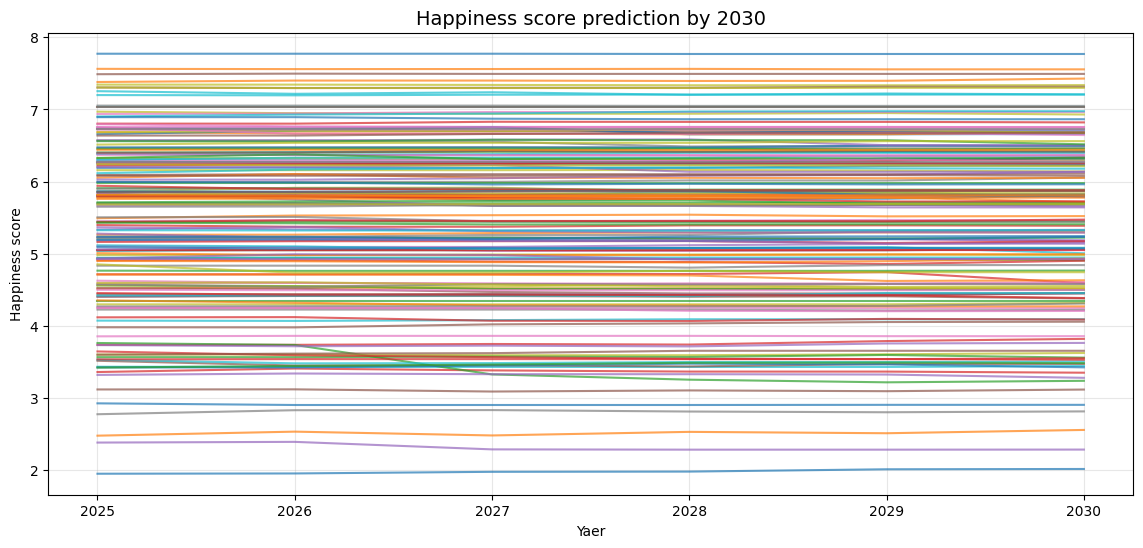

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for country in future_df['Country'].unique():
    country_data = future_df[future_df['Country'] == country].sort_values('Year')
    plt.plot(country_data['Year'], country_data['Predicted_happiness'], alpha=0.7)

plt.title('Happiness score prediction by 2030', fontsize=14)
plt.xlabel('Yaer')
plt.ylabel('Happiness score')
plt.grid(True, alpha=0.3)
plt.show()

## TimeSeriesSplit cross-validation for XGBoost

In [38]:
X_cv = X_train
y_cv = y_train

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

rmse_folds = []
mae_folds = []
r2_folds = []

print('TimeSeriesSplit (expanding window) for XGBoost on the training set\n')
print(f'Total observations in train: {X_cv.shape[0]}\n')

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_cv), start=1):
    X_tr, X_val = X_cv[train_idx], X_cv[val_idx]
    y_tr, y_val = y_cv.iloc[train_idx], y_cv.iloc[val_idx]

    model_cv = clone(model_xgb)
    model_cv.fit(X_tr, y_tr)

    y_val_pred = model_cv.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    rmse_folds.append(rmse)
    mae_folds.append(mae)
    r2_folds.append(r2)

    print(f'Fold {fold}:')
    print(f'  train idx: {train_idx[0]} .. {train_idx[-1]}')
    print(f'  val   idx: {val_idx[0]} .. {val_idx[-1]}')
    print(f'  RMSE = {rmse:.3f}, MAE = {mae:.3f}, R² = {r2:.3f}\n')

print('Average metrics across folds:')
print(f'  RMSE: {np.mean(rmse_folds):.3f}')
print(f'  MAE : {np.mean(mae_folds):.3f}')
print(f'  R²  : {np.mean(r2_folds):.3f}')

TimeSeriesSplit (expanding window) for XGBoost on the training set

Total observations in train: 810

Fold 1:
  train idx: 0 .. 134
  val   idx: 135 .. 269
  RMSE = 0.311, MAE = 0.210, R² = 0.929

Fold 2:
  train idx: 0 .. 269
  val   idx: 270 .. 404
  RMSE = 0.168, MAE = 0.133, R² = 0.977

Fold 3:
  train idx: 0 .. 404
  val   idx: 405 .. 539
  RMSE = 0.155, MAE = 0.118, R² = 0.976

Fold 4:
  train idx: 0 .. 539
  val   idx: 540 .. 674
  RMSE = 0.194, MAE = 0.138, R² = 0.970

Fold 5:
  train idx: 0 .. 674
  val   idx: 675 .. 809
  RMSE = 0.108, MAE = 0.085, R² = 0.988

Average metrics across folds:
  RMSE: 0.187
  MAE : 0.137
  R²  : 0.968
